# Problem 3 - Transfer learning: Shallow learning vs Finetuning

In this problem we will train a convolutional neural network for image classification using transfer learning. Transfer learning involves training a base network from scratch on a very large dataset (e.g., Imagenet1K with 1.2 M images and 1K categories) and then using this base network either as a feature extractor or as an initialization network for target task. Thus two major transfer learning scenarios are as follows:


• Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however the learning rate schedule for transfer learning may be different.

• Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. 

This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
For this problem the following resources will be helpful.
References
• Pytorch blog. Transfer Learning for Computer Vision Tutorial by S. Chilamkurthy Available at https://pytorch.org/tutorials/beginner/transfer learning tutorial.html
• Notes on Transfer Learning. CS231n Convolutional Neural Networks for Visual Recognition. Available at https://cs231n.github.io/transfer-learning/
• Visual Domain Decathlon


1. For fine-tuning you will select a target dataset from the Visual-Decathlon challenge. Their web site (link below) has several datasets which you can download. Select any one of the visual decathlon dataset and make it your target dataset for transfer learning. Important : Do not select Imagenet1K as the target dataset.

In [1]:
import tensorflow_datasets as tfds
from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch 

stats = ((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))

data_transforms = {
    'train': transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)]),
    'val': transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize(*stats)

    ]),
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = {'train':datasets.CIFAR100(root='./data', train=True, download=True, 
transform=data_transforms['train']),
    "val":datasets.CIFAR100(root='./data', train=False, download=True, 
transform=data_transforms['val'])}



  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
batch_size = 64
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=3),
    'val': DataLoader(data['val'], batch_size=batch_size*2, shuffle=True,num_workers=3)
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

(a) Finetuning: You will first load a pretrained model (Resnet50) and change the final fully connected layer output to the number of classes in the target dataset. Describe your target dataset features, number of classes and distribution of images per class (i.e., number of images per class). Show any 4 sample images (belonging to 2 different classes) from your target dataset. (2+2)

***Answer:***

The CIFAR-100 dataset contains 50,000 training and 10,000 test images of 20 object classes, along with 100 object subclasses. It is traditional to train on the 100 object subclasses. Each image is an RGB image of size 32x3

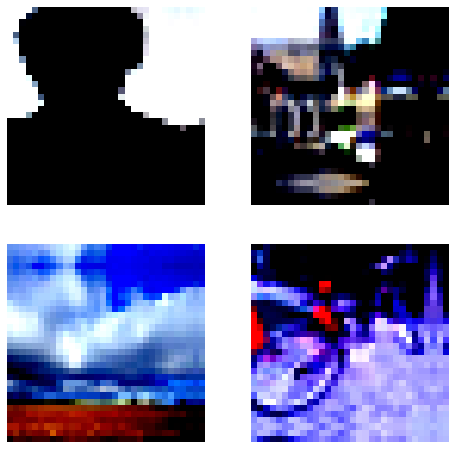

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataloaders['train']), size=(1,)).item()
    img, label = data['train'][sample_idx]
    figure.add_subplot(rows, cols, i)
    npimg = img.numpy()
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [5]:
# pretrained model.
resnet = models.resnet50(pretrained=True)

num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

(b) First finetune by setting the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers. Keep batch size of 64 and train for 50-60 epochs or until model converges well. You will use a multi-step learning rate schedule and decay by a factor of 0.1 (γ = 0.1 in the link below). You can choose steps at which you want to decay the learning rate but do 3 drops during the training. So the first drop will bring down the learning rate to 0.0001, second to 0.00001, third to 0.000001. For example, if training for 60 epochs, first drop can happen at epoch 15, second at epoch 30 and third at epoch 45. (6)


In [6]:
import time
import os
import copy
dataset_sizes = {x: len(data[x]) for x in ['train', 'val']}
#dictiorany to store the data across epochs
training_data = {"epoch":[],'train_acc':[],"test_acc":[]}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    training_data["epoch"] = []
    training_data['train_acc'] = []
    training_data["test_acc"] = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            training_data['epoch'].append(epoch+1)
            if phase =='train':
              training_data['train_acc'].append(epoch_acc)
            else:
              training_data['test_acc'].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
# Function created by me to print a 
def print_history(data):
  import matplotlib.pyplot as plt

  new_data  = {}
  for k, v in data.items():
    if k is not 'epoch':
      v = [ float(i.detach().to("cpu").numpy()) for i in v]
      new_data[k] = v

  plt.plot(list(set(data['epoch'])),new_data['train_acc'],label= "Training Accuracy")
  plt.plot(list(set(data['epoch'])),new_data['test_acc'],label= "Validation Accuracy")
  plt.legend()
  plt.show()

In [8]:
epochs = 40
step = 10

criterion = nn.CrossEntropyLoss()

# setting hyperparameter values.
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.001,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_1 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)


Epoch 0/39
----------
train Loss: 2.9805 Acc: 0.2821
val Loss: 1.9673 Acc: 0.4659

Epoch 1/39
----------
train Loss: 1.9197 Acc: 0.4765
val Loss: 1.6541 Acc: 0.5393

Epoch 2/39
----------
train Loss: 1.6344 Acc: 0.5448
val Loss: 1.5467 Acc: 0.5696

Epoch 3/39
----------
train Loss: 1.4637 Acc: 0.5858
val Loss: 1.4778 Acc: 0.5872

Epoch 4/39
----------
train Loss: 1.3276 Acc: 0.6191
val Loss: 1.4173 Acc: 0.6009

Epoch 5/39
----------
train Loss: 1.2237 Acc: 0.6472
val Loss: 1.4022 Acc: 0.6101

Epoch 6/39
----------
train Loss: 1.1355 Acc: 0.6689
val Loss: 1.3776 Acc: 0.6187

Epoch 7/39
----------
train Loss: 1.0574 Acc: 0.6899
val Loss: 1.3469 Acc: 0.6292

Epoch 8/39
----------
train Loss: 0.9913 Acc: 0.7064
val Loss: 1.3456 Acc: 0.6281

Epoch 9/39
----------
train Loss: 0.9206 Acc: 0.7280
val Loss: 1.3499 Acc: 0.6333

Epoch 10/39
----------
train Loss: 0.7562 Acc: 0.7736
val Loss: 1.2621 Acc: 0.6563

Epoch 11/39
----------
train Loss: 0.7004 Acc: 0.7910
val Loss: 1.2496 Acc: 0.6565

Ep

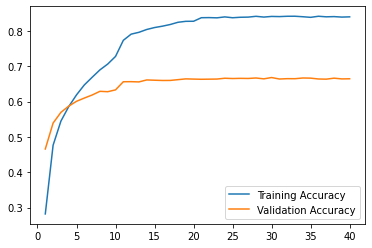

In [9]:
print_history(training_data)



(c) Next keeping all the hyperparameters (including multi-step learning rate schedule) same as before, change the learning rate to 0.01 and 0.1 uniformly for all the layers. This means keep all the layers at same learning rate. So you will be doing two experiments, one keeping learning rate of all layers at 0.01 and one with 0.1. Again finetune the model and report the final accuracy. How does the accuracy with the three learning rates compare ? Which learning rate gives you the best accuracy on the target dataset ? 

In [10]:
# experiment with initial learning rate of 0.1
resnet = models.resnet50(pretrained=True)

num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.1,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_2 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)


Epoch 0/39
----------
train Loss: 4.5729 Acc: 0.0360
val Loss: 4.1397 Acc: 0.0687

Epoch 1/39
----------
train Loss: 4.0441 Acc: 0.0743
val Loss: 3.9198 Acc: 0.0966

Epoch 2/39
----------
train Loss: 3.8253 Acc: 0.1048
val Loss: 3.7606 Acc: 0.1326

Epoch 3/39
----------
train Loss: 3.6899 Acc: 0.1292
val Loss: 3.6202 Acc: 0.1495

Epoch 4/39
----------
train Loss: 3.5889 Acc: 0.1456
val Loss: 3.4023 Acc: 0.1837

Epoch 5/39
----------
train Loss: 3.4295 Acc: 0.1735
val Loss: 3.3289 Acc: 0.2073

Epoch 6/39
----------
train Loss: 3.2909 Acc: 0.1966
val Loss: 3.1992 Acc: 0.2214

Epoch 7/39
----------
train Loss: 3.1721 Acc: 0.2172
val Loss: 3.0738 Acc: 0.2590

Epoch 8/39
----------
train Loss: 3.0759 Acc: 0.2378
val Loss: 3.1372 Acc: 0.2399

Epoch 9/39
----------
train Loss: 3.1035 Acc: 0.2322
val Loss: 2.9991 Acc: 0.2649

Epoch 10/39
----------
train Loss: 2.7728 Acc: 0.2980
val Loss: 2.7456 Acc: 0.3180

Epoch 11/39
----------
train Loss: 2.6924 Acc: 0.3124
val Loss: 2.7081 Acc: 0.3294

Ep

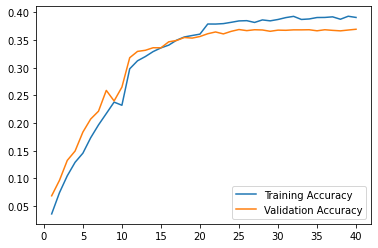

In [11]:
print_history(training_data)

In [12]:
# experiment with initial learning rate of 0.01
resnet = models.resnet50(pretrained=True)

num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.01,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_3 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

Epoch 0/39
----------
train Loss: 2.9122 Acc: 0.2767
val Loss: 3.0357 Acc: 0.3775

Epoch 1/39
----------
train Loss: 2.3793 Acc: 0.3805
val Loss: 2.5077 Acc: 0.3541

Epoch 2/39
----------
train Loss: 2.1850 Acc: 0.4193
val Loss: 1.9344 Acc: 0.4881

Epoch 3/39
----------
train Loss: 1.8426 Acc: 0.4915
val Loss: 1.8211 Acc: 0.5201

Epoch 4/39
----------
train Loss: 1.7610 Acc: 0.5107
val Loss: 1.7134 Acc: 0.5480

Epoch 5/39
----------
train Loss: 1.6488 Acc: 0.5388
val Loss: 1.8854 Acc: 0.5231

Epoch 6/39
----------
train Loss: 1.6694 Acc: 0.5361
val Loss: 1.9526 Acc: 0.5407

Epoch 7/39
----------
train Loss: 1.4535 Acc: 0.5847
val Loss: 1.5632 Acc: 0.5781

Epoch 8/39
----------
train Loss: 1.3451 Acc: 0.6130
val Loss: 1.5652 Acc: 0.5816

Epoch 9/39
----------
train Loss: 1.3354 Acc: 0.6172
val Loss: 3.1480 Acc: 0.3615

Epoch 10/39
----------
train Loss: 1.4642 Acc: 0.5883
val Loss: 1.5323 Acc: 0.5834

Epoch 11/39
----------
train Loss: 1.1412 Acc: 0.6693
val Loss: 1.6528 Acc: 0.6010

Ep

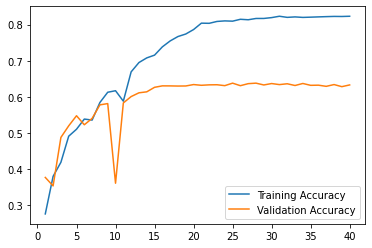

In [13]:
print_history(training_data)

***Answer:***

Using the initial learning rate of 0.001 gives me the best accuracy in this dataset.

2. When using a pretrained model as feature extractor, all the layers of the network are frozen except the final layer. Thus except the last layer, none of the inner layers’ gradients are updated during backward pass with the target dataset. Since gradients do not need to be computed for most of the network, this is faster than finetuning.

(a) Now train only the last layer for 1, 0.1, 0.01, and 0.001 while keeping all the other hyperparameters and settings same as earlier for finetuning. Which learning rate gives you the best accuracy on the target dataset ? (6)

In [14]:
# freeze resnet weights
# start with lr =1

epochs = 40
step = 10

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

optimizer = torch.optim.SGD(resnet.parameters(),lr = 1,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_4 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)


Epoch 0/39
----------
train Loss: 143.4770 Acc: 0.1329
val Loss: 162.8962 Acc: 0.1743

Epoch 1/39
----------
train Loss: 147.7955 Acc: 0.1704
val Loss: 149.1542 Acc: 0.1980

Epoch 2/39
----------
train Loss: 150.1334 Acc: 0.1837
val Loss: 164.4403 Acc: 0.2028

Epoch 3/39
----------
train Loss: 150.7827 Acc: 0.1924
val Loss: 180.3307 Acc: 0.1973

Epoch 4/39
----------
train Loss: 154.3752 Acc: 0.1976
val Loss: 199.1113 Acc: 0.1983

Epoch 5/39
----------
train Loss: 153.2598 Acc: 0.2020
val Loss: 171.8840 Acc: 0.2163

Epoch 6/39
----------
train Loss: 151.8256 Acc: 0.2091
val Loss: 154.5750 Acc: 0.2202

Epoch 7/39
----------
train Loss: 153.5606 Acc: 0.2135
val Loss: 168.4267 Acc: 0.2161

Epoch 8/39
----------
train Loss: 154.4218 Acc: 0.2143
val Loss: 167.7627 Acc: 0.2198

Epoch 9/39
----------
train Loss: 155.2577 Acc: 0.2165
val Loss: 158.8483 Acc: 0.2337

Epoch 10/39
----------
train Loss: 100.3730 Acc: 0.2744
val Loss: 103.2360 Acc: 0.2844

Epoch 11/39
----------
train Loss: 81.1296

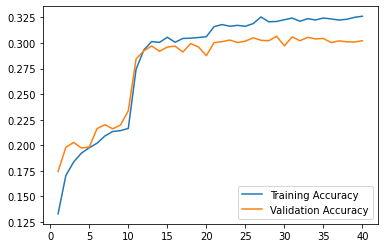

In [15]:
print_history(training_data)

In [16]:
#frozen weights 
#initial lr = 0.1

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.1,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_5 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

Epoch 0/39
----------
train Loss: 12.5057 Acc: 0.1389
val Loss: 13.9496 Acc: 0.1808

Epoch 1/39
----------
train Loss: 13.8288 Acc: 0.1752
val Loss: 15.5083 Acc: 0.1843

Epoch 2/39
----------
train Loss: 13.8938 Acc: 0.1905
val Loss: 14.1488 Acc: 0.2195

Epoch 3/39
----------
train Loss: 14.1809 Acc: 0.1974
val Loss: 15.1230 Acc: 0.2171

Epoch 4/39
----------
train Loss: 14.2566 Acc: 0.2032
val Loss: 14.9182 Acc: 0.2119

Epoch 5/39
----------
train Loss: 14.3325 Acc: 0.2092
val Loss: 13.7668 Acc: 0.2349

Epoch 6/39
----------
train Loss: 14.2649 Acc: 0.2162
val Loss: 15.1934 Acc: 0.2235

Epoch 7/39
----------
train Loss: 14.3252 Acc: 0.2148
val Loss: 15.5567 Acc: 0.2267

Epoch 8/39
----------
train Loss: 14.2849 Acc: 0.2198
val Loss: 15.4193 Acc: 0.2227

Epoch 9/39
----------
train Loss: 14.3379 Acc: 0.2205
val Loss: 15.9494 Acc: 0.2255

Epoch 10/39
----------
train Loss: 9.4718 Acc: 0.2823
val Loss: 9.1202 Acc: 0.2908

Epoch 11/39
----------
train Loss: 7.6862 Acc: 0.2971
val Loss: 8.

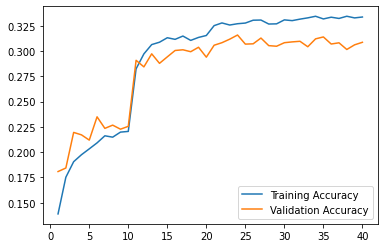

In [17]:
print_history(training_data)

In [18]:
#frozen weights 
#initial lr =  0.01

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.01,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_6 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

Epoch 0/39
----------
train Loss: 3.6214 Acc: 0.1938
val Loss: 3.3713 Acc: 0.2519

Epoch 1/39
----------
train Loss: 3.3294 Acc: 0.2455
val Loss: 3.2483 Acc: 0.2743

Epoch 2/39
----------
train Loss: 3.2322 Acc: 0.2613
val Loss: 3.2865 Acc: 0.2786

Epoch 3/39
----------
train Loss: 3.1951 Acc: 0.2685
val Loss: 3.3379 Acc: 0.2786

Epoch 4/39
----------
train Loss: 3.1509 Acc: 0.2772
val Loss: 3.1465 Acc: 0.2932

Epoch 5/39
----------
train Loss: 3.1085 Acc: 0.2827
val Loss: 3.2295 Acc: 0.2847

Epoch 6/39
----------
train Loss: 3.0741 Acc: 0.2867
val Loss: 3.1025 Acc: 0.2991

Epoch 7/39
----------
train Loss: 3.0586 Acc: 0.2937
val Loss: 3.1171 Acc: 0.3073

Epoch 8/39
----------
train Loss: 3.0400 Acc: 0.2960
val Loss: 3.1338 Acc: 0.3053

Epoch 9/39
----------
train Loss: 3.0236 Acc: 0.2973
val Loss: 3.2172 Acc: 0.2974

Epoch 10/39
----------
train Loss: 2.7576 Acc: 0.3348
val Loss: 2.8699 Acc: 0.3285

Epoch 11/39
----------
train Loss: 2.6943 Acc: 0.3405
val Loss: 2.7751 Acc: 0.3407

Ep

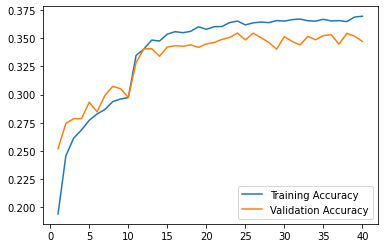

In [19]:
print_history(training_data)

In [20]:
#frozen weights 
#initial lr =  0.01

resnet = models.resnet50(pretrained=True)


for param in resnet.parameters():
    param.requires_grad = False


num_features = resnet.fc.in_features

# the fully connected layer with to classify the 100 classes

resnet.fc = nn.Linear(num_features,100)

# sending to device , Following tutorial.
resnet.to(device)

# learning rate to 0.01
optimizer = torch.optim.SGD(resnet.parameters(),lr = 0.001,momentum = 0.9)

# multistep learning rate schedule

step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step,gamma = 0.1)

model_7 = train_model(resnet, criterion, optimizer, step_lr_scheduler, num_epochs=epochs)

Epoch 0/39
----------
train Loss: 4.0293 Acc: 0.1400
val Loss: 3.5791 Acc: 0.2184

Epoch 1/39
----------
train Loss: 3.4768 Acc: 0.2249
val Loss: 3.3250 Acc: 0.2475

Epoch 2/39
----------
train Loss: 3.2979 Acc: 0.2466
val Loss: 3.2536 Acc: 0.2699

Epoch 3/39
----------
train Loss: 3.1983 Acc: 0.2617
val Loss: 3.1240 Acc: 0.2767

Epoch 4/39
----------
train Loss: 3.1245 Acc: 0.2715
val Loss: 3.1349 Acc: 0.2762

Epoch 5/39
----------
train Loss: 3.0840 Acc: 0.2756
val Loss: 3.0203 Acc: 0.2928

Epoch 6/39
----------
train Loss: 3.0456 Acc: 0.2836
val Loss: 2.9879 Acc: 0.2964

Epoch 7/39
----------
train Loss: 3.0135 Acc: 0.2895
val Loss: 2.9827 Acc: 0.3008

Epoch 8/39
----------
train Loss: 2.9836 Acc: 0.2929
val Loss: 2.9382 Acc: 0.3049

Epoch 9/39
----------
train Loss: 2.9724 Acc: 0.2924
val Loss: 2.9271 Acc: 0.3065

Epoch 10/39
----------
train Loss: 2.9353 Acc: 0.3015
val Loss: 2.9683 Acc: 0.3034

Epoch 11/39
----------
train Loss: 2.9171 Acc: 0.3038
val Loss: 2.9344 Acc: 0.3093

Ep

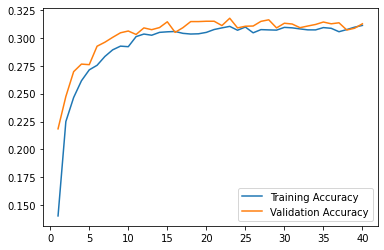

In [21]:
print_history(training_data)

(b) For your target dataset find the best final accuracy (across all the learning rates) from the two transfer learning approaches. Which approach and learning rate is the winner? Provide a plausible explanation to support your observation

***Answer:***

Using the finetuning transfer learning approches we can achieve better accuracy values. Given that we are picking a goog starting learning rate. 

We get better accuracy on the finetuning approach because we still get to training the neurons with our dataset, while with the feature extraction approach we are just training the last layer of the model. 
